# Generative Models

## GANs & VAE

### HW4

**Full Name: Payam Taebi**

**SID:400104867**

In this notebook, we are going to implement Variational AutoEncoder (VAE) and Generative Adversarial Network (GAN) on the MNIST dataset. VAEs learn a latent variable model from input data. They sample from this distribution and decode it to generate new data. GANs uses a generator to make images based on a prior distribution.


+ Complete the `TODO` parts in the code accordingly.

In [1]:
from torch.utils.data import DataLoader, random_split
from torch import optim
from tqdm.notebook import tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = device

# Dataset

We will be using MNIST dataset which consists of 60000 data. We split them into train and validation sets, each having 50000 and 10000 data respectively.

In [2]:
transformation = transforms.Compose([
        transforms.ToTensor(),
    ])

In [3]:
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

train_data, valid_data = random_split(mnist_data, [50000, 10000])

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5464481.71it/s] 


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 158058.06it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1513451.00it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2189715.95it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
num_threads = 4

batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_threads)

val_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, num_workers=num_threads)

# VAE

Variational Autoencoders (VAEs) are a class of generative models that aim to learn the probability distribution of a given dataset in order to generate new data points that resemble the original data. They use and encoder that embeds each data to a smaller latent space and a decoder that tries to generate the original image, given this latent space.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/VAE_Basic.png/425px-VAE_Basic.png)
---


In [5]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc2_log_var = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        z_mean = self.fc2_mean(x)
        z_log_var = self.fc2_log_var(x)
        return z_mean, z_log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()

        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        z = torch.relu(self.fc1(z))
        x = torch.sigmoid(self.fc2(z))
        return x


In [6]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, z_mean, z_log_var):
        epsilon = torch.randn_like(z_mean)
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon # log var 2log(sigma) e ye 1/2 mikhad

    def forward(self, x):
        z_mean, z_log_var = self.encoder(x)
        z = self.reparameterize(z_mean, z_log_var)
        image = self.decoder(z)
        return image, z_mean, z_log_var


In [7]:
!pip install torchsummary
from torchsummary import summary

# Define the model
input_dim = 784  # Example input dimension for MNIST data 28 dar 28
hidden_dim = 256
latent_dim = 20  # Example latent dimension
vae_model = VAE(input_dim, hidden_dim, latent_dim).to(DEVICE)
# Print the summary
summary(vae_model, (input_dim,))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
            Linear-2                   [-1, 20]           5,140
            Linear-3                   [-1, 20]           5,140
           Encoder-4       [[-1, 20], [-1, 20]]               0
            Linear-5                  [-1, 256]           5,376
            Linear-6                  [-1, 784]         201,488
           Decoder-7                  [-1, 784]               0
Total params: 418,104
Trainable params: 418,104
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.59
Estimated Total Size (MB): 1.61
----------------------------------------------------------------


In [8]:
def reconstruct_images(vae, images):
    with torch.no_grad():
        recon_images, _, _ = vae(images)
    return recon_images

class VAE_Loss(nn.Module):
    def __init__(self):
        super(VAE_Loss, self).__init__()

    def forward(self, x, recon_x, z_mean, z_log_var):

        reconstruction_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')

        kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())

        total_loss = reconstruction_loss + kl_loss

        return total_loss

import matplotlib.pyplot as plt

def plot_reconstructed_images(original_images, reconstructed_images, epoch):
    num_images = min(original_images.size(0), 4)
    fig, axes = plt.subplots(num_images, 2, figsize=(8, 8))

    original_images = original_images.cpu().detach().numpy()
    reconstructed_images = reconstructed_images.cpu().detach().numpy()

    for i in range(num_images):
        # Reshape original and reconstructed images to 28x28
        original_image = np.reshape(original_images[i], (28, 28))
        reconstructed_image = np.reshape(reconstructed_images[i], (28, 28))

        # Plot original images
        axes[i, 0].imshow(original_image, cmap='gray')
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        # Plot reconstructed images
        axes[i, 1].imshow(reconstructed_image, cmap='gray')
        axes[i, 1].set_title('Reconstructed Image')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.savefig(f"reconstructed_images_epoch_{epoch}.png")
    plt.show()


In [9]:
import torch.optim as optim
from tqdm import tqdm

def train_vae(dataloader, latent_dim, hidden_dim, input_dim, learning_rate=1e-4, num_epochs=1):

    model = VAE(input_dim, hidden_dim, latent_dim).to(DEVICE)
    criterion = VAE_Loss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Get a batch of sample images from the validation loader
    sample_images, _ = next(iter(val_loader))
    sample_images = sample_images.view(sample_images.size(0), -1).to(DEVICE)
    #print(sample_images.shape)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, data in pbar:
                inputs = data[0].to(DEVICE)
                inputs = inputs.view(inputs.size(0), -1)
                #print(inputs.shape)
                optimizer.zero_grad()
                recon_images, z_mean, z_log_var = model(inputs)

                loss = criterion(inputs, recon_images, z_mean, z_log_var)
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * inputs.size(0)

                pbar.set_description(f"Epoch [{epoch + 1}/{num_epochs}]")
                pbar.set_postfix(train_loss=train_loss / len(dataloader.dataset))

        # Print average loss for the epoch
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss / len(dataloader.dataset)))

        # Reconstruct and plot sample images
        if epoch % 10 == 0:
            recon_image = reconstruct_images(model, sample_images)
            plot_reconstructed_images(sample_images, recon_image, epoch)

    return model


Epoch [1/70]: 100%|██████████| 782/782 [00:07<00:00, 109.21it/s, train_loss=2.85e+3]


Epoch [1/70], Loss: 2847.7322


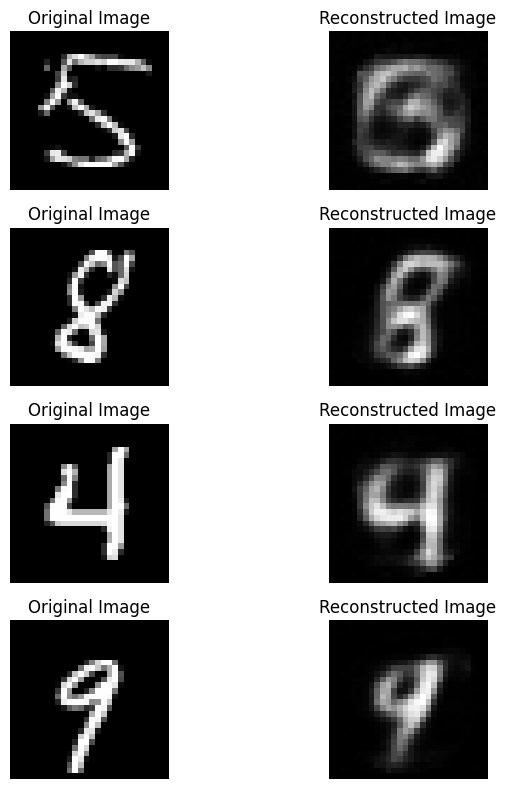

Epoch [2/70]: 100%|██████████| 782/782 [00:06<00:00, 120.23it/s, train_loss=2.23e+3]

Epoch [2/70], Loss: 2231.0558



Epoch [3/70]: 100%|██████████| 782/782 [00:06<00:00, 120.72it/s, train_loss=2.12e+3]


Epoch [3/70], Loss: 2124.4229


Epoch [4/70]: 100%|██████████| 782/782 [00:06<00:00, 124.30it/s, train_loss=2.07e+3]

Epoch [4/70], Loss: 2072.5945



Epoch [5/70]: 100%|██████████| 782/782 [00:06<00:00, 113.92it/s, train_loss=2.04e+3]

Epoch [5/70], Loss: 2039.3825



Epoch [6/70]: 100%|██████████| 782/782 [00:06<00:00, 125.89it/s, train_loss=2.02e+3]

Epoch [6/70], Loss: 2018.3837



Epoch [7/70]: 100%|██████████| 782/782 [00:06<00:00, 129.78it/s, train_loss=2e+3]


Epoch [7/70], Loss: 2003.5189


Epoch [8/70]: 100%|██████████| 782/782 [00:06<00:00, 128.11it/s, train_loss=1.99e+3]

Epoch [8/70], Loss: 1991.5442



Epoch [9/70]: 100%|██████████| 782/782 [00:05<00:00, 130.70it/s, train_loss=1.98e+3]

Epoch [9/70], Loss: 1981.8399



Epoch [10/70]: 100%|██████████| 782/782 [00:06<00:00, 118.00it/s, train_loss=1.97e+3]

Epoch [10/70], Loss: 1973.4281



Epoch [11/70]: 100%|██████████| 782/782 [00:06<00:00, 124.72it/s, train_loss=1.97e+3]


Epoch [11/70], Loss: 1966.5349


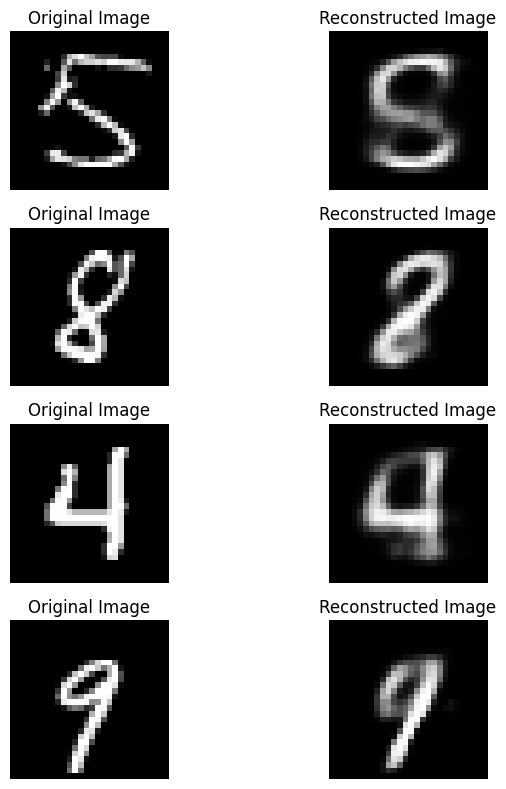

Epoch [12/70]: 100%|██████████| 782/782 [00:06<00:00, 130.22it/s, train_loss=1.96e+3]

Epoch [12/70], Loss: 1960.7782



Epoch [13/70]: 100%|██████████| 782/782 [00:06<00:00, 126.89it/s, train_loss=1.95e+3]

Epoch [13/70], Loss: 1954.5670



Epoch [14/70]: 100%|██████████| 782/782 [00:06<00:00, 128.50it/s, train_loss=1.95e+3]

Epoch [14/70], Loss: 1949.8011



Epoch [15/70]: 100%|██████████| 782/782 [00:06<00:00, 116.57it/s, train_loss=1.94e+3]


Epoch [15/70], Loss: 1943.8071


Epoch [16/70]: 100%|██████████| 782/782 [00:06<00:00, 116.96it/s, train_loss=1.94e+3]

Epoch [16/70], Loss: 1940.2277



Epoch [17/70]: 100%|██████████| 782/782 [00:06<00:00, 119.72it/s, train_loss=1.94e+3]

Epoch [17/70], Loss: 1938.5370



Epoch [18/70]: 100%|██████████| 782/782 [00:06<00:00, 120.18it/s, train_loss=1.93e+3]


Epoch [18/70], Loss: 1931.2878


Epoch [19/70]: 100%|██████████| 782/782 [00:06<00:00, 119.08it/s, train_loss=1.93e+3]


Epoch [19/70], Loss: 1929.5415


Epoch [20/70]: 100%|██████████| 782/782 [00:07<00:00, 105.31it/s, train_loss=1.93e+3]

Epoch [20/70], Loss: 1926.5229



Epoch [21/70]: 100%|██████████| 782/782 [00:06<00:00, 119.61it/s, train_loss=1.93e+3]


Epoch [21/70], Loss: 1925.5854


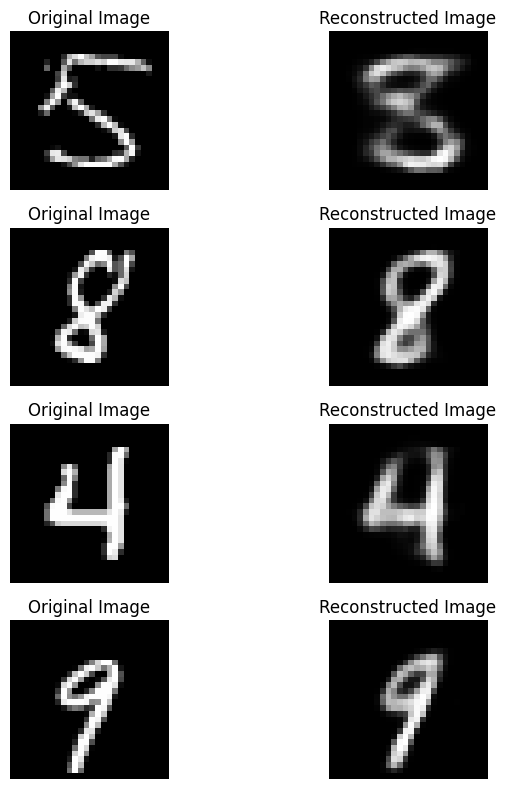

Epoch [22/70]: 100%|██████████| 782/782 [00:06<00:00, 120.41it/s, train_loss=1.92e+3]

Epoch [22/70], Loss: 1919.6945



Epoch [23/70]: 100%|██████████| 782/782 [00:06<00:00, 117.30it/s, train_loss=1.92e+3]


Epoch [23/70], Loss: 1919.3258


Epoch [24/70]: 100%|██████████| 782/782 [00:07<00:00, 110.53it/s, train_loss=1.92e+3]

Epoch [24/70], Loss: 1915.7639



Epoch [25/70]: 100%|██████████| 782/782 [00:06<00:00, 112.75it/s, train_loss=1.91e+3]

Epoch [25/70], Loss: 1912.6144



Epoch [26/70]: 100%|██████████| 782/782 [00:06<00:00, 118.47it/s, train_loss=1.91e+3]


Epoch [26/70], Loss: 1909.1983


Epoch [27/70]: 100%|██████████| 782/782 [00:06<00:00, 123.02it/s, train_loss=1.91e+3]

Epoch [27/70], Loss: 1906.5510



Epoch [28/70]: 100%|██████████| 782/782 [00:06<00:00, 125.64it/s, train_loss=1.91e+3]


Epoch [28/70], Loss: 1905.7878


Epoch [29/70]: 100%|██████████| 782/782 [00:06<00:00, 113.88it/s, train_loss=1.9e+3]

Epoch [29/70], Loss: 1903.2020



Epoch [30/70]: 100%|██████████| 782/782 [00:06<00:00, 114.44it/s, train_loss=1.9e+3]

Epoch [30/70], Loss: 1900.1476



Epoch [31/70]: 100%|██████████| 782/782 [00:06<00:00, 118.04it/s, train_loss=1.9e+3]


Epoch [31/70], Loss: 1898.8490


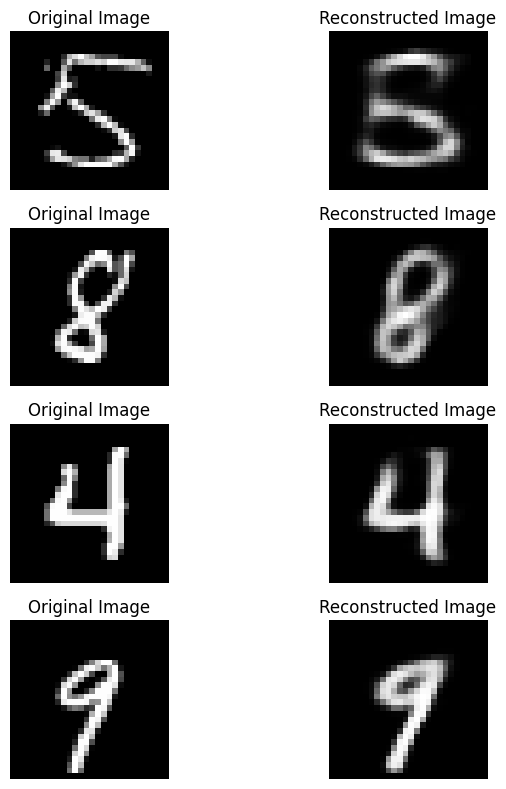

Epoch [32/70]: 100%|██████████| 782/782 [00:06<00:00, 122.00it/s, train_loss=1.9e+3]

Epoch [32/70], Loss: 1897.8835



Epoch [33/70]: 100%|██████████| 782/782 [00:06<00:00, 119.36it/s, train_loss=1.89e+3]

Epoch [33/70], Loss: 1893.5308



Epoch [34/70]: 100%|██████████| 782/782 [00:06<00:00, 118.15it/s, train_loss=1.89e+3]

Epoch [34/70], Loss: 1892.3612



Epoch [35/70]: 100%|██████████| 782/782 [00:06<00:00, 118.91it/s, train_loss=1.89e+3]

Epoch [35/70], Loss: 1890.9766



Epoch [36/70]: 100%|██████████| 782/782 [00:06<00:00, 114.82it/s, train_loss=1.89e+3]

Epoch [36/70], Loss: 1891.3792



Epoch [37/70]: 100%|██████████| 782/782 [00:06<00:00, 121.41it/s, train_loss=1.89e+3]

Epoch [37/70], Loss: 1890.2413



Epoch [38/70]: 100%|██████████| 782/782 [00:06<00:00, 114.78it/s, train_loss=1.89e+3]

Epoch [38/70], Loss: 1887.2844



Epoch [39/70]: 100%|██████████| 782/782 [00:06<00:00, 122.24it/s, train_loss=1.89e+3]

Epoch [39/70], Loss: 1885.6977



Epoch [40/70]: 100%|██████████| 782/782 [00:06<00:00, 122.42it/s, train_loss=1.89e+3]

Epoch [40/70], Loss: 1885.3412



Epoch [41/70]: 100%|██████████| 782/782 [00:06<00:00, 116.14it/s, train_loss=1.88e+3]


Epoch [41/70], Loss: 1883.2227


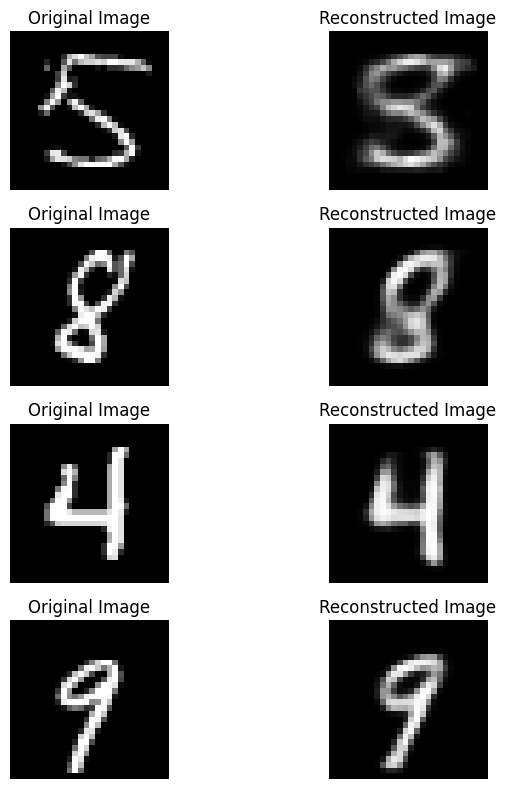

Epoch [42/70]: 100%|██████████| 782/782 [00:06<00:00, 117.37it/s, train_loss=1.88e+3]


Epoch [42/70], Loss: 1882.3139


Epoch [43/70]: 100%|██████████| 782/782 [00:06<00:00, 115.80it/s, train_loss=1.88e+3]


Epoch [43/70], Loss: 1880.3706


Epoch [44/70]: 100%|██████████| 782/782 [00:06<00:00, 120.86it/s, train_loss=1.88e+3]

Epoch [44/70], Loss: 1877.5703



Epoch [45/70]: 100%|██████████| 782/782 [00:06<00:00, 120.75it/s, train_loss=1.88e+3]

Epoch [45/70], Loss: 1878.3561



Epoch [46/70]: 100%|██████████| 782/782 [00:06<00:00, 119.97it/s, train_loss=1.88e+3]


Epoch [46/70], Loss: 1877.9340


Epoch [47/70]: 100%|██████████| 782/782 [00:06<00:00, 121.67it/s, train_loss=1.88e+3]

Epoch [47/70], Loss: 1875.5651



Epoch [48/70]: 100%|██████████| 782/782 [00:06<00:00, 116.63it/s, train_loss=1.88e+3]

Epoch [48/70], Loss: 1875.3474



Epoch [49/70]: 100%|██████████| 782/782 [00:06<00:00, 122.07it/s, train_loss=1.87e+3]

Epoch [49/70], Loss: 1874.3946



Epoch [50/70]: 100%|██████████| 782/782 [00:06<00:00, 122.99it/s, train_loss=1.87e+3]


Epoch [50/70], Loss: 1874.2622


Epoch [51/70]: 100%|██████████| 782/782 [00:06<00:00, 119.66it/s, train_loss=1.87e+3]


Epoch [51/70], Loss: 1870.9757


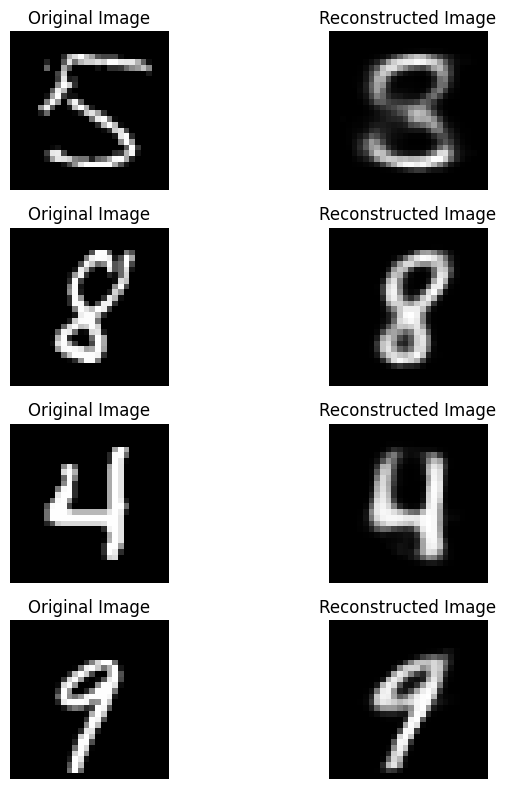

Epoch [52/70]: 100%|██████████| 782/782 [00:07<00:00, 106.61it/s, train_loss=1.87e+3]

Epoch [52/70], Loss: 1869.6880



Epoch [53/70]: 100%|██████████| 782/782 [00:06<00:00, 123.54it/s, train_loss=1.87e+3]

Epoch [53/70], Loss: 1870.5812



Epoch [54/70]: 100%|██████████| 782/782 [00:06<00:00, 121.78it/s, train_loss=1.87e+3]

Epoch [54/70], Loss: 1868.1223



Epoch [55/70]: 100%|██████████| 782/782 [00:06<00:00, 121.41it/s, train_loss=1.87e+3]

Epoch [55/70], Loss: 1867.6195



Epoch [56/70]: 100%|██████████| 782/782 [00:06<00:00, 121.65it/s, train_loss=1.87e+3]


Epoch [56/70], Loss: 1867.6172


Epoch [57/70]: 100%|██████████| 782/782 [00:06<00:00, 115.27it/s, train_loss=1.87e+3]


Epoch [57/70], Loss: 1866.2642


Epoch [58/70]: 100%|██████████| 782/782 [00:06<00:00, 122.99it/s, train_loss=1.86e+3]


Epoch [58/70], Loss: 1864.9440


Epoch [59/70]: 100%|██████████| 782/782 [00:06<00:00, 123.11it/s, train_loss=1.86e+3]

Epoch [59/70], Loss: 1864.6485



Epoch [60/70]: 100%|██████████| 782/782 [00:06<00:00, 121.87it/s, train_loss=1.86e+3]


Epoch [60/70], Loss: 1864.8220


Epoch [61/70]: 100%|██████████| 782/782 [00:06<00:00, 119.83it/s, train_loss=1.86e+3]


Epoch [61/70], Loss: 1862.4784


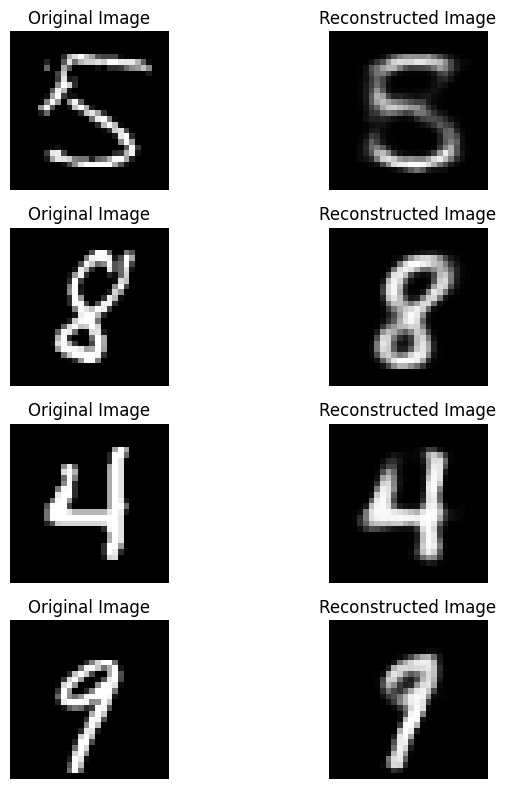

Epoch [62/70]: 100%|██████████| 782/782 [00:06<00:00, 113.77it/s, train_loss=1.86e+3]


Epoch [62/70], Loss: 1862.5547


Epoch [63/70]: 100%|██████████| 782/782 [00:07<00:00, 110.46it/s, train_loss=1.86e+3]

Epoch [63/70], Loss: 1859.6165



Epoch [64/70]: 100%|██████████| 782/782 [00:06<00:00, 121.88it/s, train_loss=1.86e+3]

Epoch [64/70], Loss: 1860.0573



Epoch [65/70]: 100%|██████████| 782/782 [00:06<00:00, 122.11it/s, train_loss=1.86e+3]


Epoch [65/70], Loss: 1859.6038


Epoch [66/70]: 100%|██████████| 782/782 [00:06<00:00, 121.49it/s, train_loss=1.86e+3]

Epoch [66/70], Loss: 1857.8109



Epoch [67/70]: 100%|██████████| 782/782 [00:06<00:00, 119.23it/s, train_loss=1.86e+3]

Epoch [67/70], Loss: 1858.7710



Epoch [68/70]: 100%|██████████| 782/782 [00:06<00:00, 123.65it/s, train_loss=1.86e+3]

Epoch [68/70], Loss: 1857.9062



Epoch [69/70]: 100%|██████████| 782/782 [00:06<00:00, 123.10it/s, train_loss=1.86e+3]

Epoch [69/70], Loss: 1856.0784



Epoch [70/70]: 100%|██████████| 782/782 [00:06<00:00, 123.45it/s, train_loss=1.86e+3]

Epoch [70/70], Loss: 1855.9231


In [10]:
latent_dim = 20
hidden_dim = 256
input_dim = 784
learning_rate = 1e-3
num_epochs = 70


model = train_vae(train_loader, latent_dim, hidden_dim, input_dim, learning_rate, num_epochs)

# GAN

GANs consist of two models: a generator and a discriminator. The generator creates new data points, and the discriminator evaluates them, trying to distinguish between real and generated (fake) data points. The training process involves updating the generator to produce more realistic data, as judged by the discriminator, and simultaneously updating the discriminator to get better at distinguishing real from fake. This adversarial process leads to improvements in both models, with the generator producing highly realistic data points as a result.

In [11]:
def noise(size, batch_size=128):
    return torch.randn(size, batch_size).to(device)

log_data = []

def log(epoch, total_epochs, batch, total_batches, discriminator_error, generator_error):
    row = {
        'epoch': epoch, 'total_epochs': total_epochs,
        'batch': batch, 'total_batches': total_batches,
        'discriminator_error': discriminator_error, 'generator_error': generator_error,
    }
    log_data.append(row)

def display_training_progress(epoch, num_epochs, batch_index, num_batches, discriminator_error, generator_error, discriminator_ratio, discriminator_feedback, batch_size=128):
    epoch_percentage = (epoch + 1) / num_epochs * 100
    batch_percentage = (batch_index * batch_size) / (num_batches * batch_size) * 100
    
    print(f"Epoch {epoch + 1}/{num_epochs} ({epoch_percentage:.1f}%):"
          f" [{batch_index * batch_size}/{num_batches * batch_size}] ({batch_percentage:.1f}%)"
          f" Discriminator Error: {discriminator_error:.4f} Generator Error: {generator_error:.4f}")

    
def display_images(images):
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(8,4))
    count = 0
    for y in range(2):
        for x in range(4):
            img = images[count].view(28, 28)
            axs[y][x].imshow(img, cmap="gray")
            count += 1
    plt.show()

In [12]:
def mnist_data():
    compose = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])])
    out_dir = '/kaggle/working/mnist/'
    return datasets.MNIST(root=out_dir, train=True,
                          transform=compose, download=True)

data_loader = DataLoader(mnist_data(), batch_size=128, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 6040775.70it/s]


Extracting /kaggle/working/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 158996.60it/s]


Extracting /kaggle/working/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:03<00:00, 451131.55it/s]


Extracting /kaggle/working/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2638942.90it/s]

Extracting /kaggle/working/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/mnist/MNIST/raw



In [13]:
class GeneratorNet(nn.Module):
    def __init__(self, batch_size=128, img_size=28):
        super(GeneratorNet, self).__init__()
        
        self.hidden0 = nn.Sequential(
            nn.Linear(batch_size, 256),
            nn.LeakyReLU(0.2),
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
        )
        self.out = nn.Sequential(
            nn.Linear(1024, img_size * img_size),
            nn.Tanh(),
        )
    
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

class DiscriminatorNet(nn.Module):
    def __init__(self, n_out=1, img_size=28):
        super(DiscriminatorNet, self).__init__()
        
        self.hidden0 = nn.Sequential(
            nn.Linear(img_size * img_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        self.out = nn.Sequential(
            nn.Linear(256, n_out),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [14]:
discriminator = DiscriminatorNet().to(device)
generator = GeneratorNet().to(device)

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
loss = nn.BCELoss()
EPOCHS = 300

In [15]:
def train_discriminator(dmodel, optimizer, loss_func, real_data, fake_data):
    optimizer.zero_grad()
    
    pred_real = dmodel(real_data)   
    error_real = loss_func(pred_real,torch.ones(real_data.size(0), 1).to(device))
    error_real.backward()
    
    pred_fake = dmodel(fake_data)
    error_fake = loss_func(pred_fake, torch.zeros(real_data.size(0), 1).to(device))
    error_fake.backward()
    
    optimizer.step()
    return error_real + error_fake, pred_real, pred_fake

def train_generator(dmodel, optimizer, loss_func, fake_data):
    optimizer.zero_grad()
    pred = dmodel(fake_data)  
    error = loss_func(pred,  torch.ones(pred.size(0), 1).to(device) )
    error.backward()
    optimizer.step()
    return error

In [16]:
NUM_BATCHES = len(data_loader)
test_noise = noise(8).to(device)

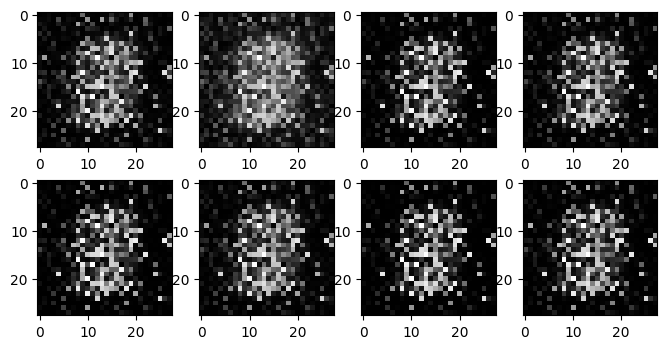

Epoch 1/300 (0.3%): [59904/60032] (99.8%) Discriminator Error: 0.6730 Generator Error: 3.1490


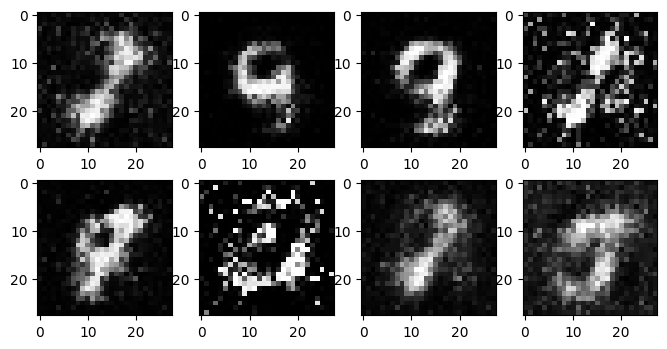

Epoch 11/300 (3.7%): [59904/60032] (99.8%) Discriminator Error: 0.6304 Generator Error: 2.2305


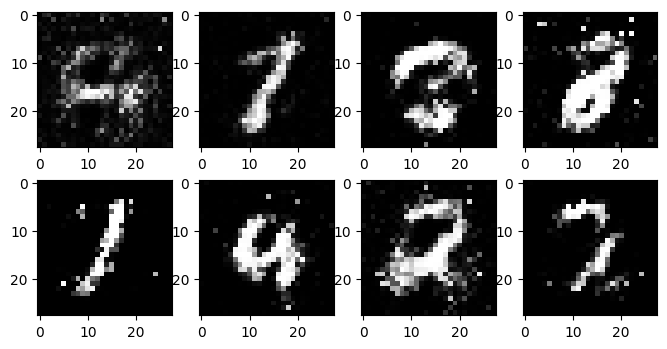

Epoch 21/300 (7.0%): [59904/60032] (99.8%) Discriminator Error: 0.5513 Generator Error: 2.4149


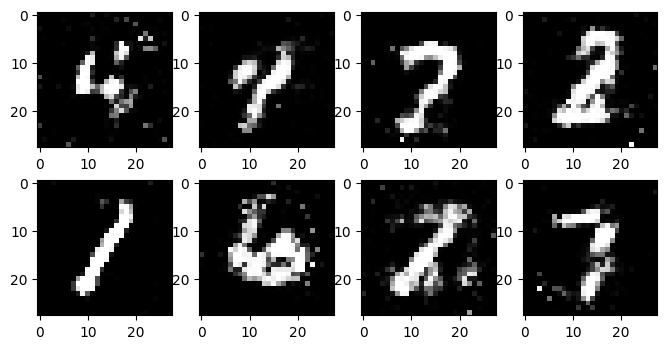

Epoch 31/300 (10.3%): [59904/60032] (99.8%) Discriminator Error: 1.0484 Generator Error: 1.5056


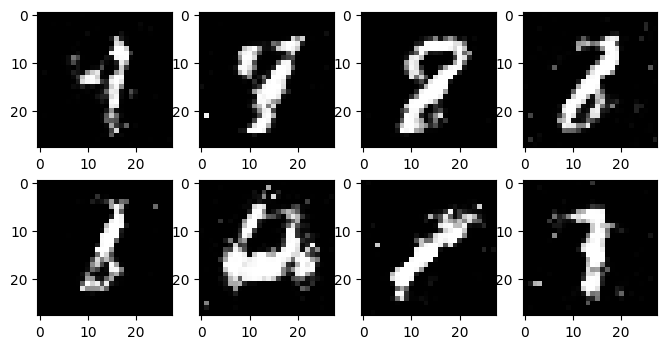

Epoch 41/300 (13.7%): [59904/60032] (99.8%) Discriminator Error: 0.9312 Generator Error: 1.4385


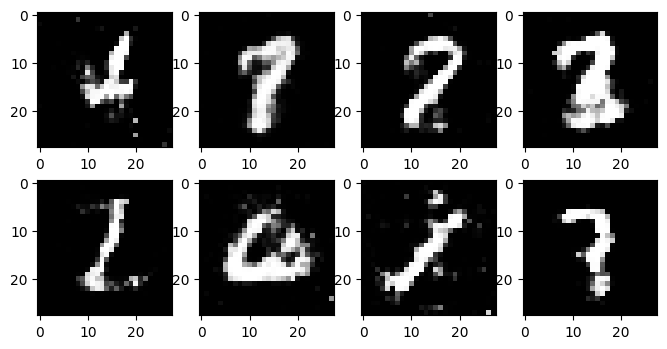

Epoch 51/300 (17.0%): [59904/60032] (99.8%) Discriminator Error: 1.0894 Generator Error: 1.1049


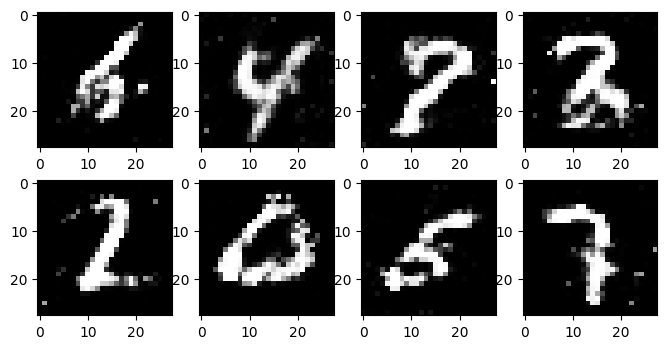

Epoch 61/300 (20.3%): [59904/60032] (99.8%) Discriminator Error: 1.1146 Generator Error: 0.9731


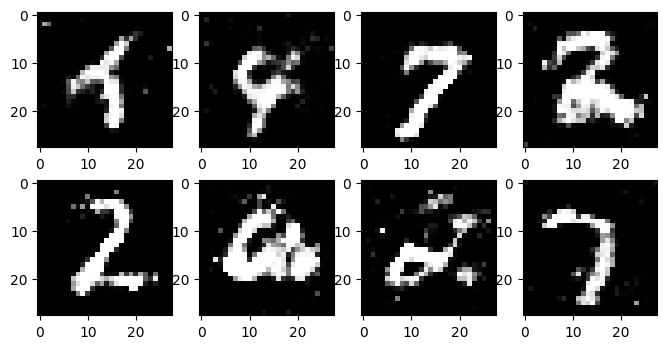

Epoch 71/300 (23.7%): [59904/60032] (99.8%) Discriminator Error: 1.1905 Generator Error: 1.2889


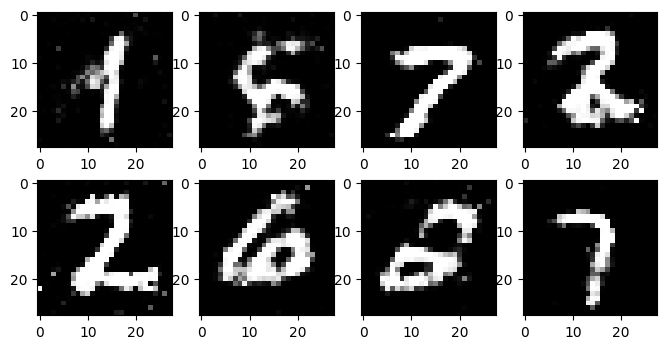

Epoch 81/300 (27.0%): [59904/60032] (99.8%) Discriminator Error: 1.1455 Generator Error: 0.9465


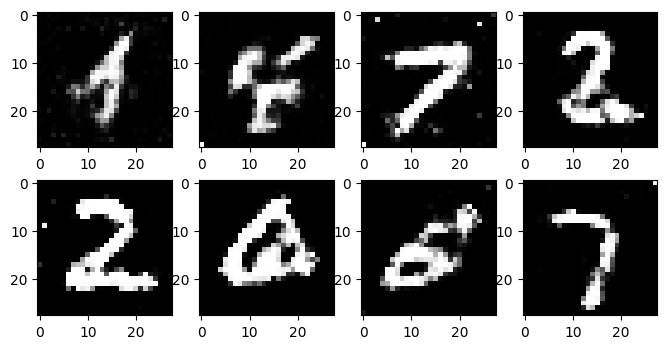

Epoch 91/300 (30.3%): [59904/60032] (99.8%) Discriminator Error: 1.2340 Generator Error: 1.0127


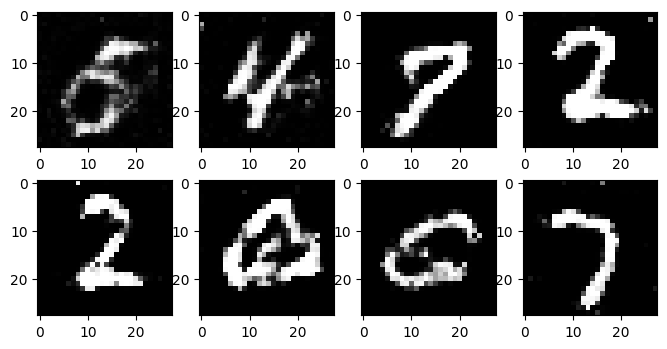

Epoch 101/300 (33.7%): [59904/60032] (99.8%) Discriminator Error: 1.2197 Generator Error: 0.8100


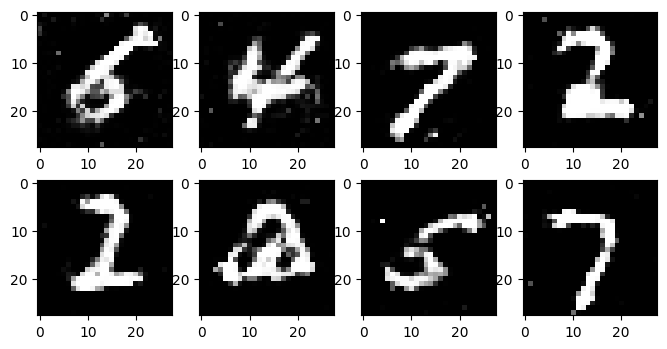

Epoch 111/300 (37.0%): [59904/60032] (99.8%) Discriminator Error: 1.3391 Generator Error: 0.9148


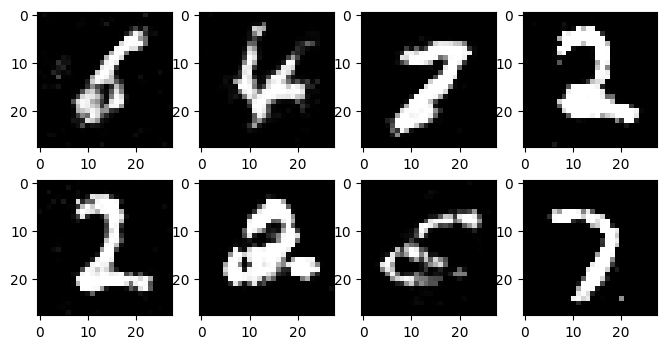

Epoch 121/300 (40.3%): [59904/60032] (99.8%) Discriminator Error: 1.0395 Generator Error: 1.1600


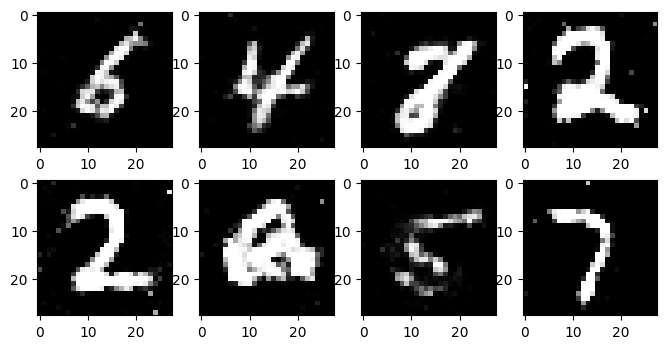

Epoch 131/300 (43.7%): [59904/60032] (99.8%) Discriminator Error: 1.2942 Generator Error: 0.9161


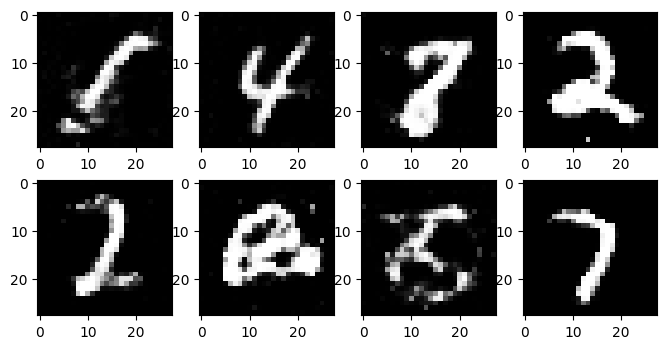

Epoch 141/300 (47.0%): [59904/60032] (99.8%) Discriminator Error: 1.2241 Generator Error: 0.9952


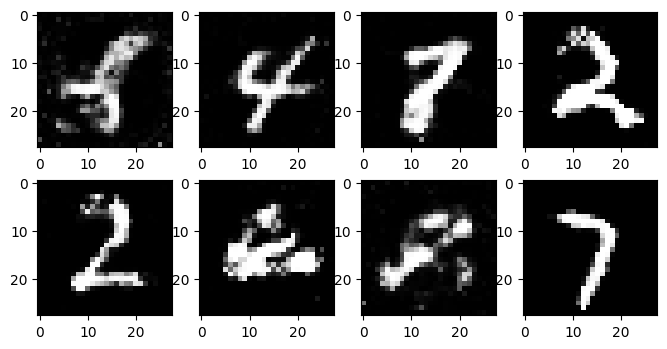

Epoch 151/300 (50.3%): [59904/60032] (99.8%) Discriminator Error: 1.2583 Generator Error: 0.9505


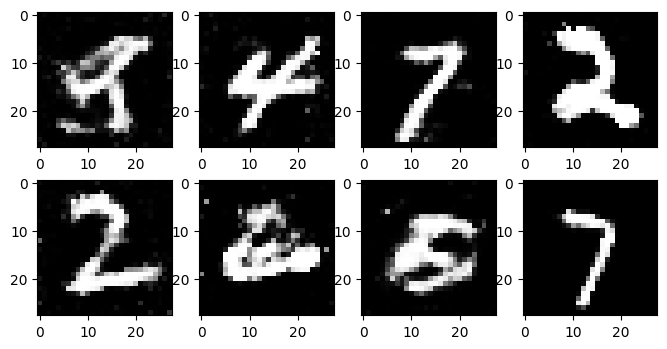

Epoch 161/300 (53.7%): [59904/60032] (99.8%) Discriminator Error: 1.3270 Generator Error: 0.8414


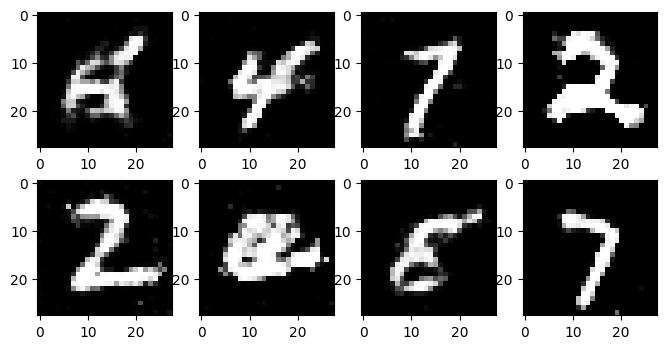

Epoch 171/300 (57.0%): [59904/60032] (99.8%) Discriminator Error: 1.2254 Generator Error: 0.8778


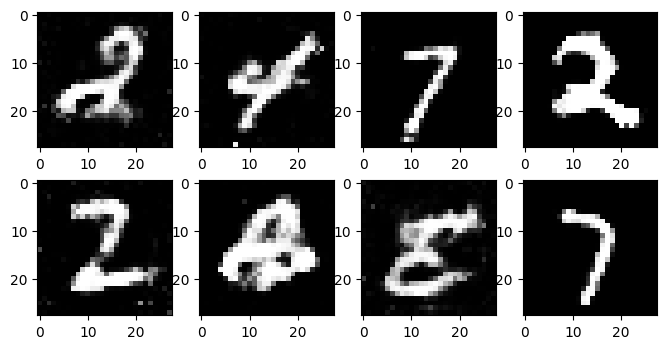

Epoch 181/300 (60.3%): [59904/60032] (99.8%) Discriminator Error: 1.2135 Generator Error: 0.8835


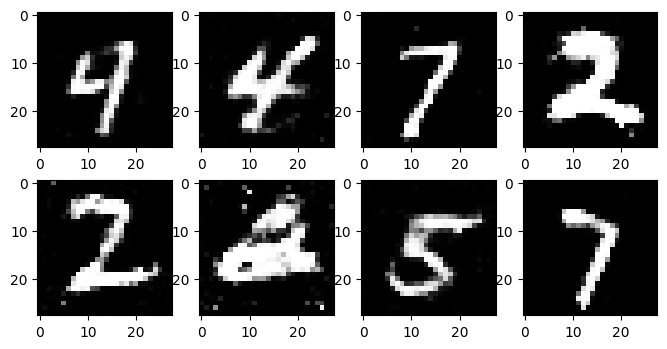

Epoch 191/300 (63.7%): [59904/60032] (99.8%) Discriminator Error: 1.2765 Generator Error: 0.9221


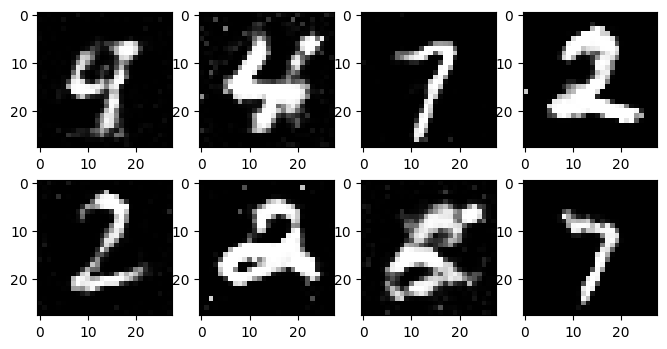

Epoch 201/300 (67.0%): [59904/60032] (99.8%) Discriminator Error: 1.2036 Generator Error: 0.9228


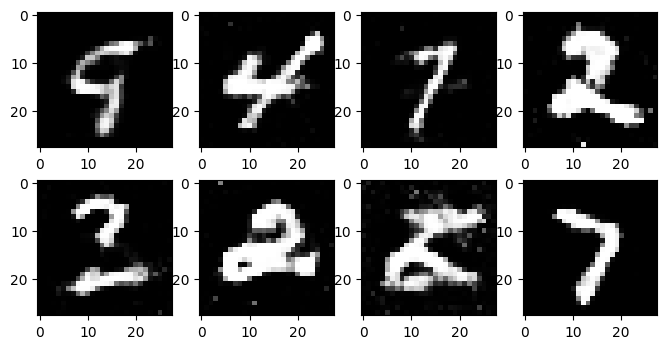

Epoch 211/300 (70.3%): [59904/60032] (99.8%) Discriminator Error: 1.3425 Generator Error: 0.9907


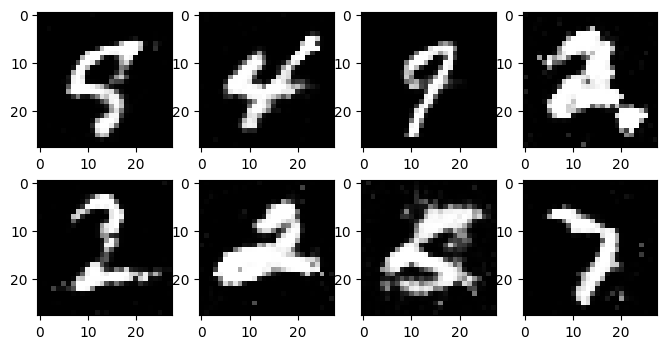

Epoch 221/300 (73.7%): [59904/60032] (99.8%) Discriminator Error: 1.2182 Generator Error: 0.9493


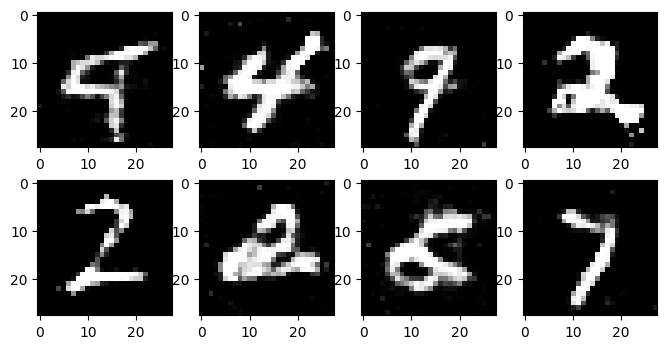

Epoch 231/300 (77.0%): [59904/60032] (99.8%) Discriminator Error: 1.3107 Generator Error: 0.9201


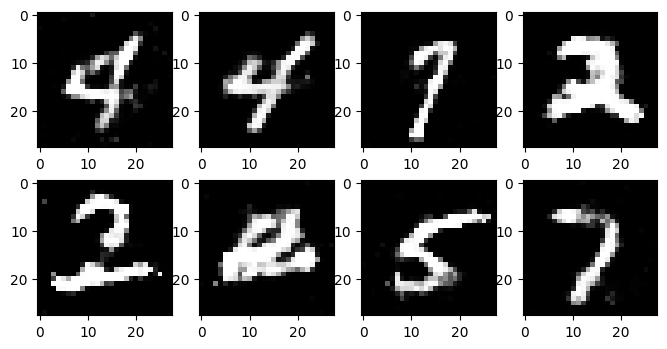

Epoch 241/300 (80.3%): [59904/60032] (99.8%) Discriminator Error: 1.3394 Generator Error: 0.9381


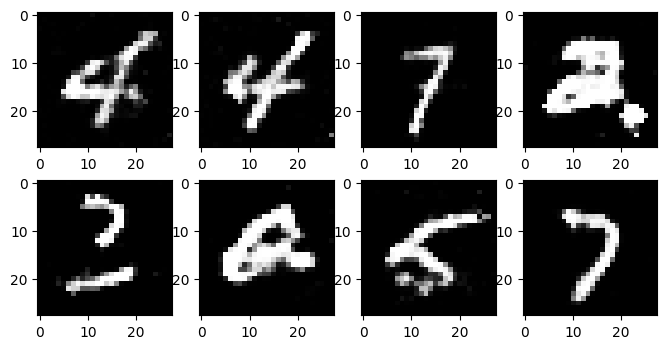

Epoch 251/300 (83.7%): [59904/60032] (99.8%) Discriminator Error: 1.2932 Generator Error: 0.8772


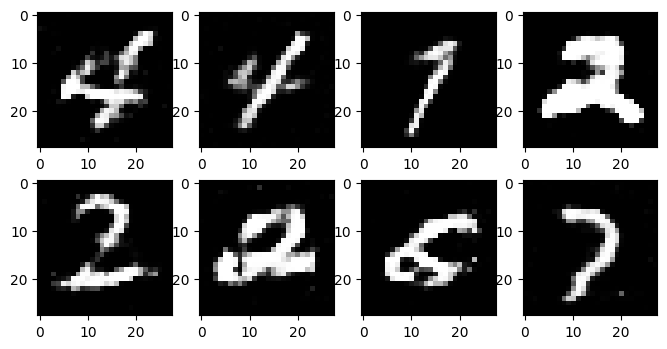

Epoch 261/300 (87.0%): [59904/60032] (99.8%) Discriminator Error: 1.2575 Generator Error: 0.8428


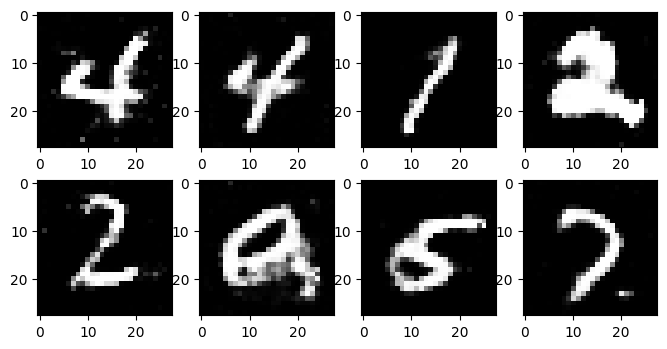

Epoch 271/300 (90.3%): [59904/60032] (99.8%) Discriminator Error: 1.3466 Generator Error: 0.9207


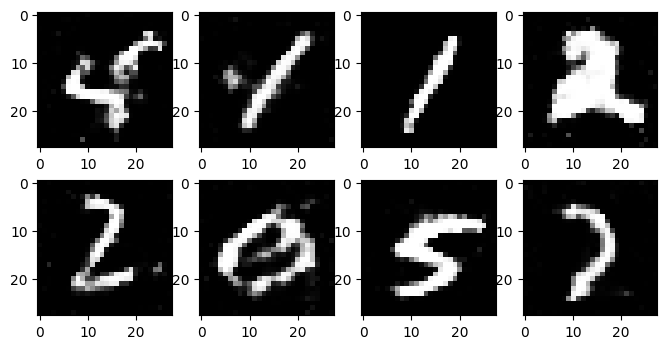

Epoch 281/300 (93.7%): [59904/60032] (99.8%) Discriminator Error: 1.1674 Generator Error: 0.8383


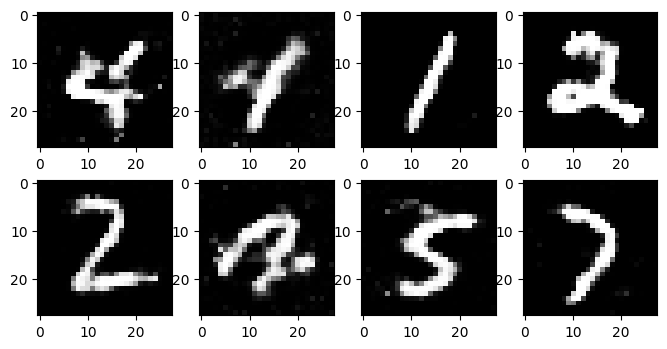

Epoch 291/300 (97.0%): [59904/60032] (99.8%) Discriminator Error: 1.3796 Generator Error: 0.7958


In [17]:
for epoch in range(EPOCHS):
    for batch_idx, (batch, _) in enumerate(data_loader):
        
        # === Train D ===
        real_data = batch.view(batch.size(0), 28 * 28).to(device)
        fake_data = generator(noise(real_data.size(0))).detach()
        d_error, d_pred_real, d_pred_fake, = train_discriminator(
            discriminator, d_optimizer, loss, real_data, fake_data)
        # === Train G ===
        fake_data = generator(noise(real_data.size(0)))
        g_error = train_generator(
            discriminator, g_optimizer, loss, fake_data)
      
    
    if epoch % 10 == 0: 
        img = generator(test_noise.to(device))

        test_images = img.view(img.size(0), 1, 28, 28).data.cpu()

        display_images(test_images)

        display_training_progress(epoch, EPOCHS, batch_idx, NUM_BATCHES,
                     d_error, g_error, d_pred_real, d_pred_fake)


# Compare

Use validation dataset to plot and compare the results of your trained models.

VAE :


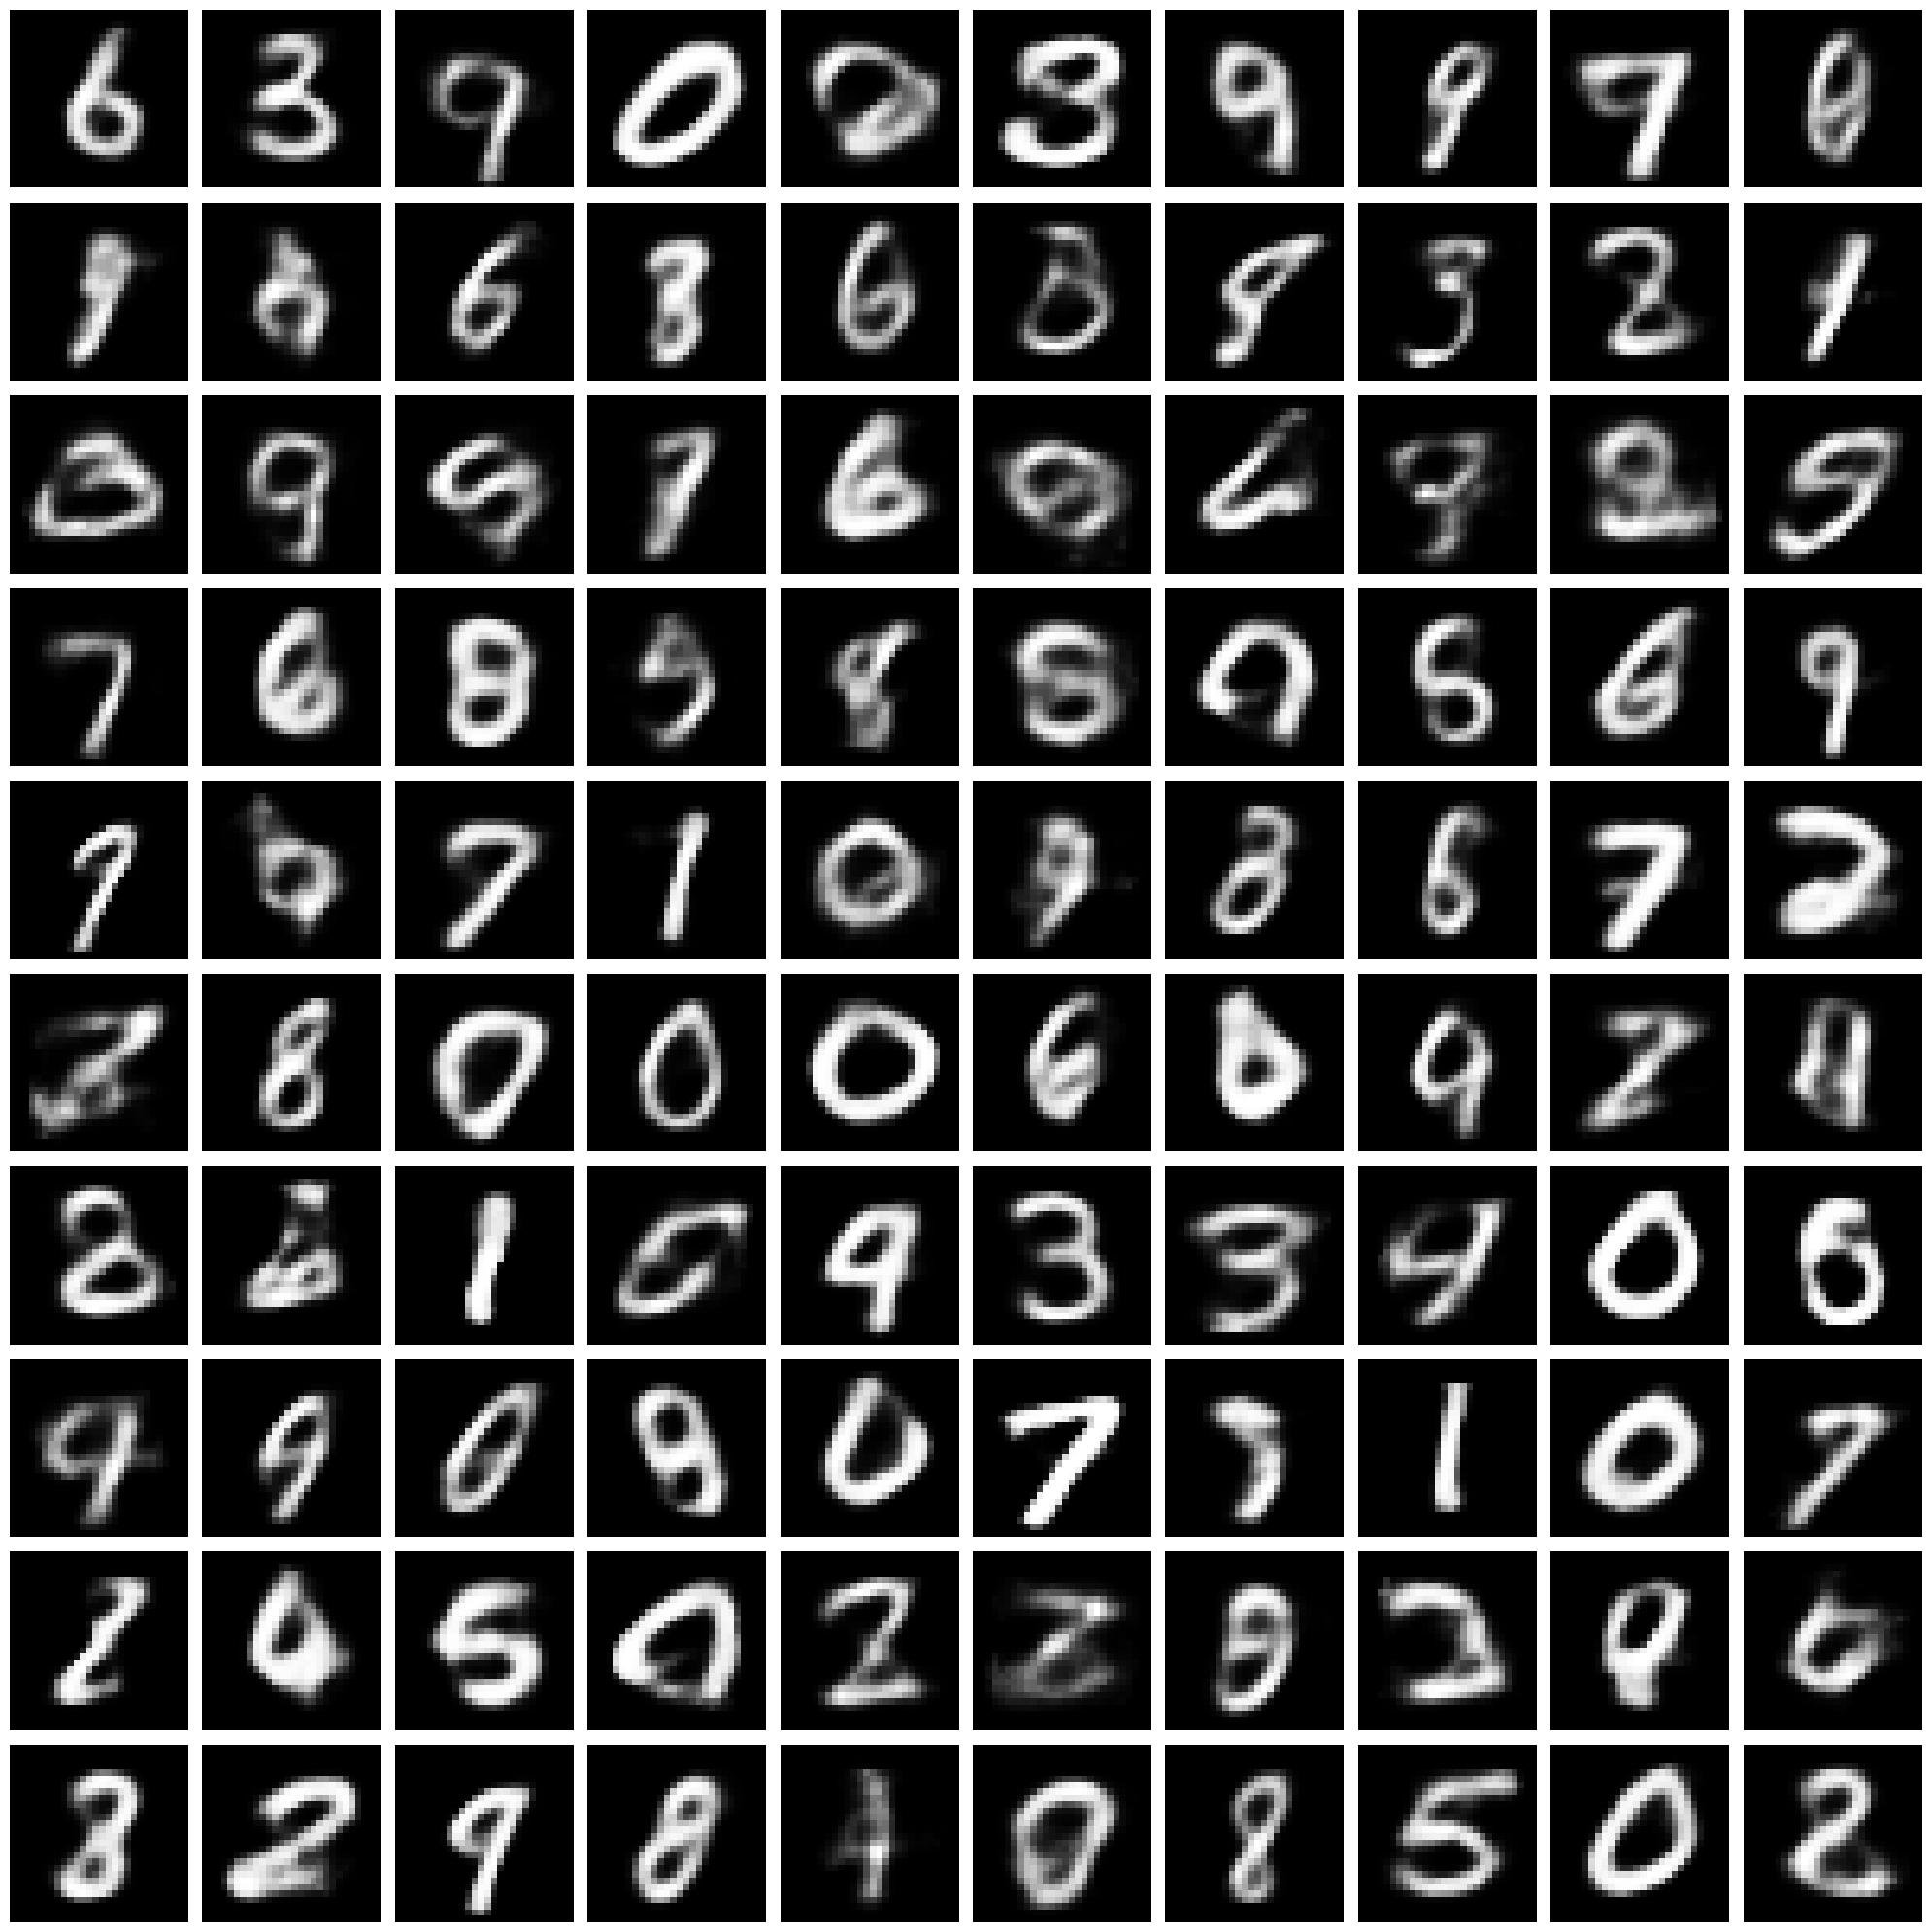

In [18]:
import torch
import matplotlib.pyplot as plt

# Define the plotting function
def plot_generated_samples(generated_images, num_cols=10):
    num_samples = generated_images.size(0)
    num_rows = (num_samples + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))

    for i in range(num_samples):
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(generated_images[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
        ax.axis('off')

    for i in range(num_samples, num_rows * num_cols):
        fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    print("VAE :")
    plt.show()

# Define the sample generation function
def generate_samples(vae_model, num_samples):

    latent_samples = torch.randn(num_samples, latent_dim).to(DEVICE)

    with torch.no_grad():
        generated_images = vae_model.decoder(latent_samples)

    return generated_images

# Example usage:
num_samples = 100  # Number of samples to generate for a 10x10 grid
generated_images = generate_samples(model, num_samples)
plot_generated_samples(generated_images, num_cols=10)


GAN :


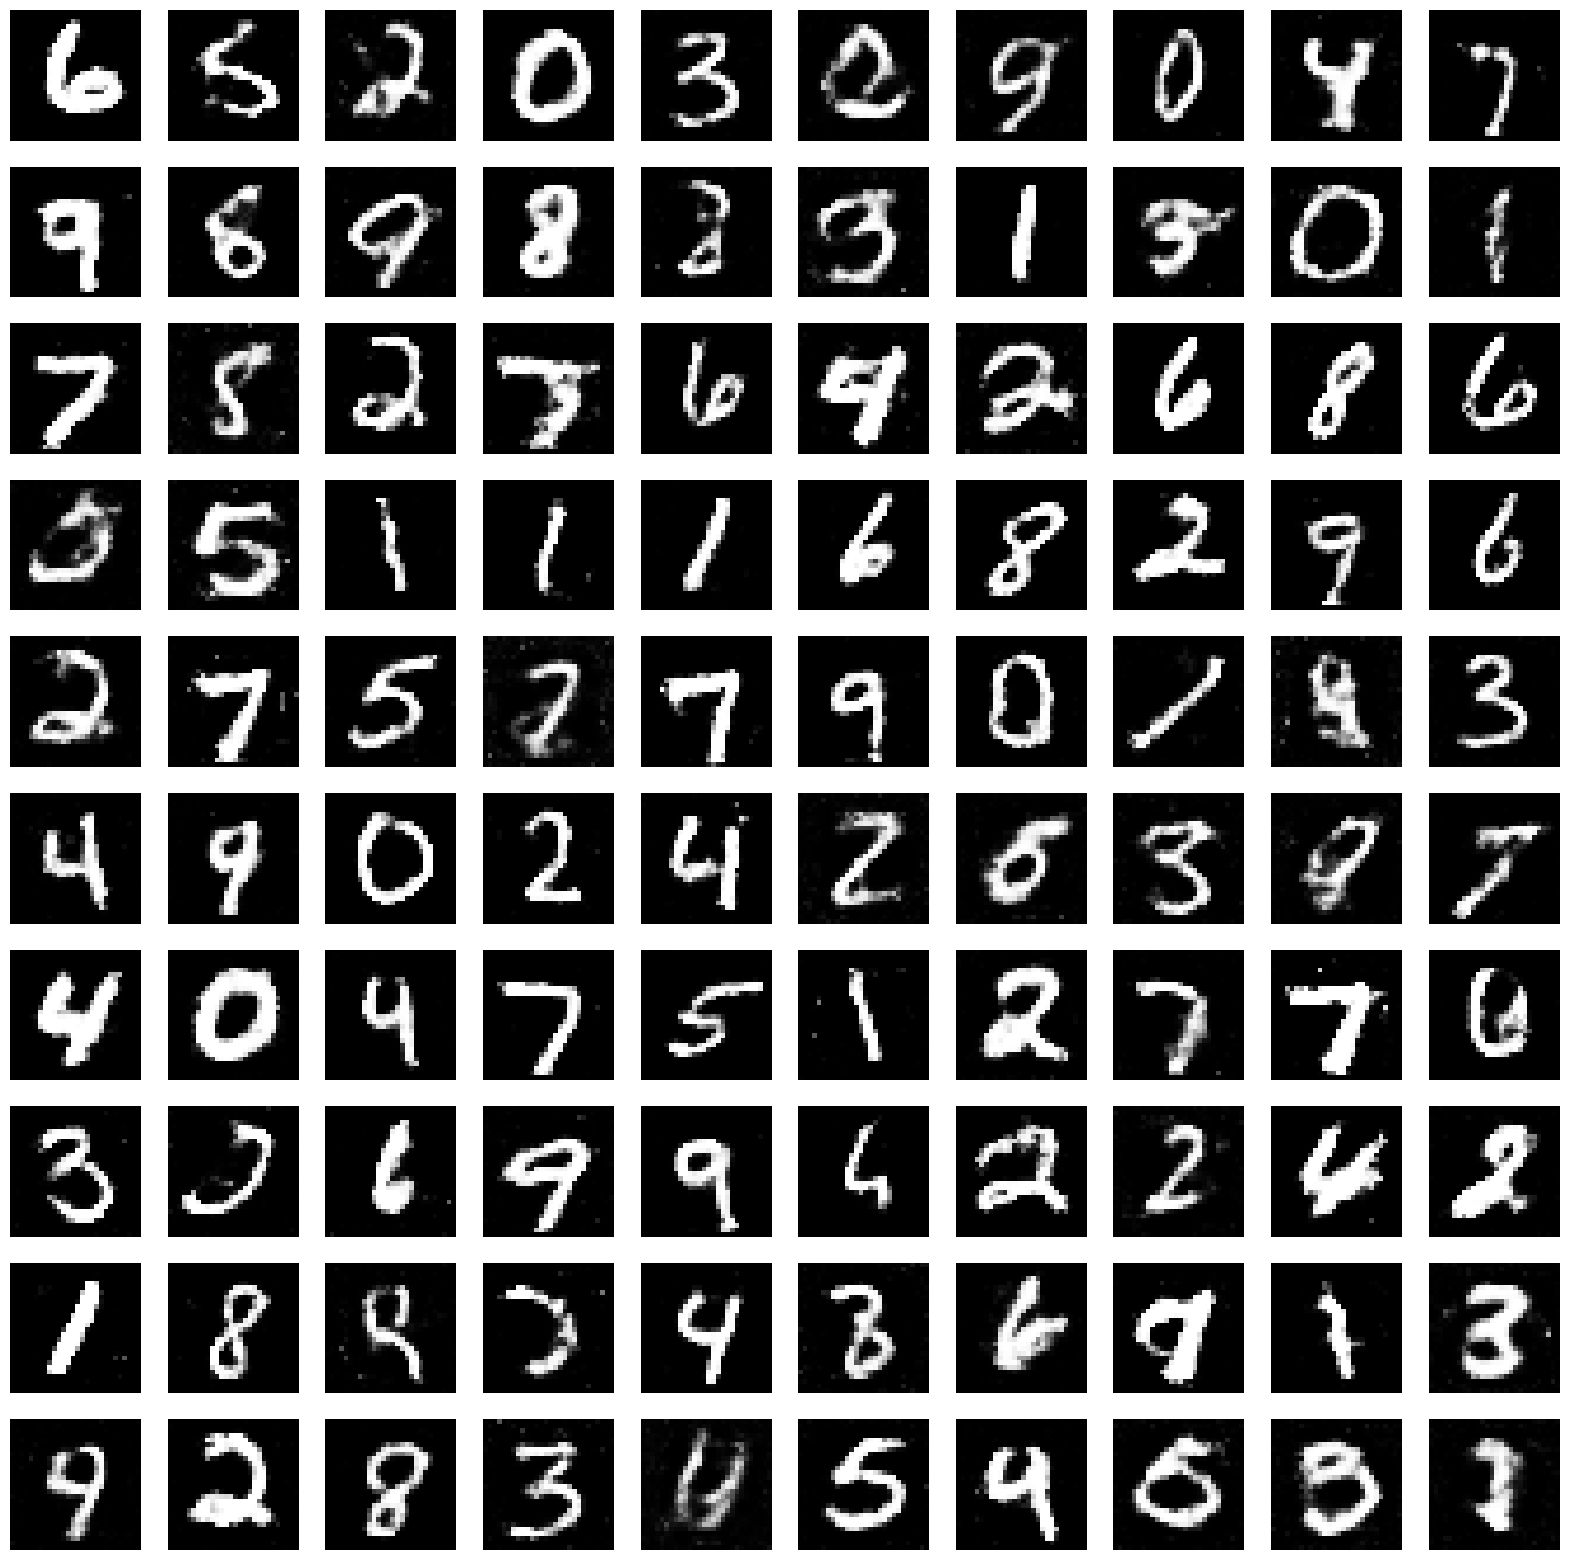

In [19]:
img = generator(noise(100).to(device))

images =  img.view(img.size(0), 1, 28, 28).data.cpu()

fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(20, 20))  # Changed to 10 rows and 10 columns
count = 0
for y in range(10):  # Iterate over 10 rows
    for x in range(10):  # Iterate over 10 columns
        img = images[count].view(28, 28)
        axs[y][x].imshow(img, cmap="gray")
        axs[y][x].axis('off')  # Turn off axis for cleaner display
        count += 1
print("GAN :")
plt.show()